### 衡量预测结果的 BDBR 性能

In [14]:
import os

import pandas as pd
pd.set_option('display.max_rows', 6)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 12,
    'text.usetex': False,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 11,
    'legend.title_fontsize': 12,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})
sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

In [ ]:
def rm_outliers(df, cols, threshold=1.5, lower_only=True):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        if lower_only:
            df = df[df[col] >= lower_bound]
        else:
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

#### 1. Bitrate - PSNR (预测的是 log2bitrate 和 log2psnr, 画图 & 保存表格)

In [90]:
import pandas as pd

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

pred_df = pd.read_csv(f"{table_dir}/predCurve/combined_preds.csv")
pred_df = pred_df.drop(columns=["p1", "p2", "p3", "pred_p1", "pred_p2", "pred_p3"])     # 不用看参数了

display(pred_df)
print(pred_df.columns.tolist())

,seqName,sceneId,regressor,input,preset,size,func,target,qp,pred_target,bitrate,log2bitrate,psnr,log2psnr,ssim,log2ssim,vmaf,log2vmaf,err
0,Lecture-42c3,0,Adam,(faster)x(360P),faster,1080P,linear,bitrate,22,675.249878,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,363.210522
1,Lecture-42c3,0,Adam,(medium)x(360P),faster,1080P,linear,bitrate,22,695.509933,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,342.950467
2,Lecture-42c3,0,Adam,(slower)x(360P),faster,1080P,linear,bitrate,22,1486.697418,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-448.237018
3,Lecture-42c3,0,Adam,(faster)x(540P),faster,1080P,linear,bitrate,22,1049.840759,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-11.380359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257788,Lecture-7e40,1,SGDRegressor,(slower)x(720P),slower,720P,quadratic3,log2vmaf,52,6.218592,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,-0.021131
4257789,Lecture-7e40,1,SGDRegressor,(faster)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.092571,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.104890
4257790,Lecture-7e40,1,SGDRegressor,(medium)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.029500,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.167961
4257791,Lecture-7e40,1,SGDRegressor,(slower)x(1080P),slower,720P,quadratic3,log2vmaf,52,5.804019,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.393442


['seqName', 'sceneId', 'regressor', 'input', 'preset', 'size', 'func', 'target', 'qp', 'pred_target', 'bitrate', 'log2bitrate', 'psnr', 'log2psnr', 'ssim', 'log2ssim', 'vmaf', 'log2vmaf', 'err']


#### 1.1 预测的是 log2psnr

In [91]:
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, verbose = args
    
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    psnr_df    = group[
        (group["target"] == "log2psnr") & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + ["log2psnr", "psnr"]].reset_index(drop=True)
    
    bitrate_df = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    psnr_df    = psnr_df.rename(columns={"pred_target": "pred_log2psnr"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(psnr_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    group_rd["pred_psnr"] = 2 ** group_rd["pred_log2psnr"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", "psnr"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", "pred_psnr"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    os.makedirs(f"{table_dir}/convex/RD-PSNR/{seqName}-scene{sceneId}", exist_ok=True)
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df.to_csv(f"{table_dir}/convex/RD-PSNR/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y="pred_psnr", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend()
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    axes[0].set_ylabel("Predicted PSNR (dB)")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y="psnr", hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend()
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel("Actual PSNR (dB)")
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    
    os.makedirs(f"{fig_dir}/convex/RD-log2PSNR/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/convex/RD-log2PSNR/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.pdf", format="pdf")
    plt.close()
    
    if verbose:
        display(group_rd)
        display(convex_df)
        plt.show()

In [92]:
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True

for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, verbose))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:05<00:00, 11.09it/s]


In [94]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/convex/RD-log2PSNR")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/convex/RD-log2PSNR/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/convex/RD-log2PSNR/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True)
display(convex_df)

convex_df.to_csv(f"{table_dir}/convex/convex_log2psnr.csv", index=False)

100%|██████████| 864/864 [00:19<00:00, 43.47it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2psnr,log2psnr,psnr,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_psnr,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,52,5.168254,5.141633,35.300897,3.682048,4.471851,22.1902,12.835327,35.958315,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,52,5.158033,5.184935,36.376495,3.880789,4.886233,29.5735,14.731057,35.704470,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,5.868936,5.664675,50.726739,12.506482,12.602524,6219.2459,5818.701542,58.442112,pred
3,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,720P,22,5.758200,5.622548,49.266957,11.518206,12.125150,4467.1839,2933.090905,54.124114,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336096,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,32,5.306039,5.274658,38.710625,8.651368,8.770086,436.5750,402.088063,39.561879,actual
336097,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,37,5.185277,5.193304,36.588125,8.013295,8.224990,299.2050,258.370022,36.385117,actual
336098,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,42,5.064514,5.064797,33.470000,7.282748,7.441077,173.7750,155.713232,33.463445,actual
336099,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,47,4.943752,4.955940,31.037500,6.459726,6.840086,114.5700,88.017975,30.776379,actual


#### BD-Rate (actual convex v.s. predicted convex)
pred convex 也是用真实的 (bitrate, psnr) 算 -> 只是通过预测 RD 选中了这些点，但编码他们的性能还是得用真实值

In [95]:
from metrics.bjontegaard import BD_RATE, BD_PSNR

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])

rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_rate = BD_RATE(actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0)
    bd_psnr = BD_PSNR(actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0)
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate, bd_psnr])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_rate", "bd_psnr"])
display(all_bdbr)

all_bdbr = rm_outliers(all_bdbr, cols=["bd_rate", "bd_psnr"], threshold=0.75)
display(all_bdbr.describe())

all_bdbr.to_csv(f"{table_dir}/convex/all_BDBR_log2PSNR.csv", index=False)

19008it [00:33, 560.81it/s]


,seqName,sceneId,regressor,func,input,preset,bd_rate,bd_psnr
0,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,9.265554,-0.672640
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,7.895104,-0.906382
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),slower,17.931427,-1.208052
3,Lecture-42c3,0,Adam,linear,(faster)x(360P),faster,1.408747,-0.107347
...,...,...,...,...,...,...,...,...
19004,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(540P),slower,10.361253,-0.188092
19005,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),faster,14.947944,-0.676341
19006,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,18.452786,-0.519531
19007,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,17.801882,-0.464658


,sceneId,bd_rate,bd_psnr
count,16813.000000,16813.000000,16813.000000
mean,3.705228,4.900341,-0.215646
std,3.553014,5.393906,0.244574
min,0.000000,-4.829215,-0.788208
25%,1.000000,1.058624,-0.400299
50%,2.000000,3.577854,-0.175875
75%,7.000000,7.377871,-0.036723
max,11.000000,54.937800,0.957684


In [96]:
# 看一下不同预测策略 (regressor, func, input) 的效果
grouped = all_bdbr.groupby(["regressor", "func", "input"], as_index=False)

rows = []
for (regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_rate"].mean(), group["bd_psnr"].mean()])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_rate", "bd_psnr"])
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/convex/avg_BDBR_log2PSNR.csv", index=False)

,regressor,func,input,bd_rate,bd_psnr
0,Adam,linear,(faster)x(1080P),6.959475,-0.309581
1,Adam,linear,(faster)x(360P),6.994373,-0.310025
2,Adam,linear,(faster)x(540P),6.105129,-0.223033
3,Adam,linear,(faster)x(720P),6.719700,-0.300190
...,...,...,...,...,...
284,SGDRegressor,quadratic3,(slower)x(1080P),5.111335,-0.172332
285,SGDRegressor,quadratic3,(slower)x(360P),7.302934,-0.307866
286,SGDRegressor,quadratic3,(slower)x(540P),2.422405,-0.090083
287,SGDRegressor,quadratic3,(slower)x(720P),3.767173,-0.117484


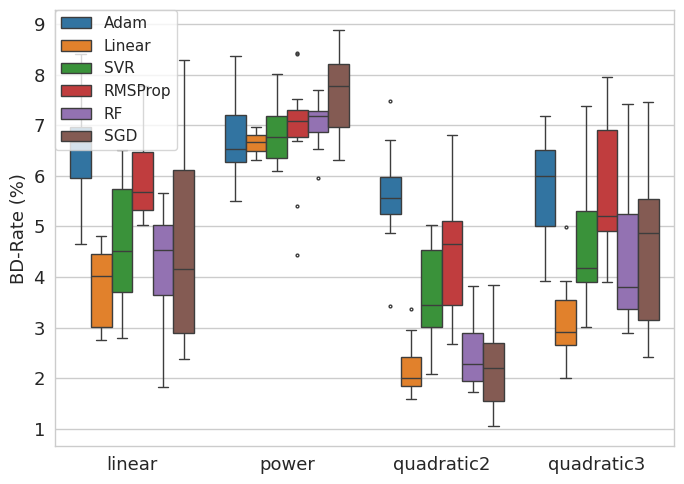

In [98]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)
plt.figure(figsize=(7, 5))

# 1. 先画一下 BD-Rate
ax = sns.boxplot(data=avg_bdbr, x="func", y="bd_rate", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-Rate (%)")
ax.legend(handles, new_labels, borderaxespad=0.)

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDRate_log2PSNR.pdf", format="pdf")

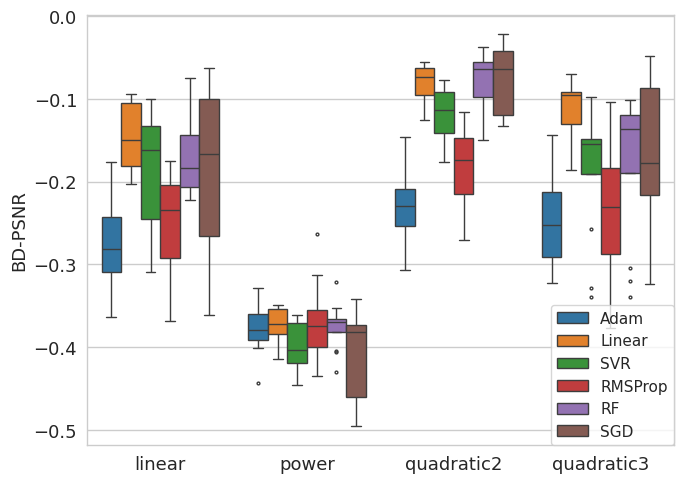

In [99]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)
plt.figure(figsize=(7, 5))

# 2. 再画一下 BD-PSNR
ax = sns.boxplot(data=avg_bdbr, x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-PSNR")
ax.legend(handles, new_labels, borderaxespad=0.)

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDBR_log2PSNR.pdf", format="pdf")

#### 1.2 预测的是 PSNR

In [100]:
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, verbose = args
    
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    psnr_df    = group[
        (group["target"] == "psnr") & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + ["log2psnr", "psnr"]].reset_index(drop=True)
    
    bitrate_df = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    psnr_df    = psnr_df.rename(columns={"pred_target": "pred_psnr"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(psnr_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", "psnr"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", "pred_psnr"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    os.makedirs(f"{table_dir}/convex/RD-PSNR/{seqName}-scene{sceneId}", exist_ok=True)
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df.to_csv(f"{table_dir}/convex/RD-PSNR/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y="pred_psnr", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend(loc="lower right")
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    axes[0].set_ylabel("Predicted PSNR")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y="psnr", hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend(loc="lower right")
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel("Actual PSNR")
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    
    os.makedirs(f"{fig_dir}/convex/RD-PSNR/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/convex/RD-PSNR/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.png")
    plt.close()
    
    if verbose:
        display(group_rd)
        display(convex_df)
        plt.show()

In [101]:
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, verbose))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:05<00:00, 11.26it/s]


#### BD-BR (PSNR)

In [102]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/convex/RD-PSNR")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/convex/RD-PSNR/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/convex/RD-PSNR/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/convex/convex_psnr.csv", index=False)

100%|██████████| 864/864 [00:19<00:00, 43.73it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_psnr,log2psnr,psnr,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,52,36.226711,5.141633,35.300897,3.682048,4.471851,22.1902,12.835327,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,52,35.241048,5.184935,36.376495,3.880789,4.886233,29.5735,14.731057,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,58.200520,5.664675,50.726739,12.506482,12.602524,6219.2459,5818.701542,pred
3,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,27,54.600597,5.583459,47.950000,11.749388,11.673958,3267.4696,3442.850007,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341441,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,32,38.591318,5.274658,38.710625,8.651368,8.770086,436.5750,402.088063,actual
341442,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,37,35.559522,5.193304,36.588125,8.013295,8.224990,299.2050,258.370022,actual
341443,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,42,32.527725,5.064797,33.470000,7.282748,7.441077,173.7750,155.713232,actual
341444,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,47,29.495929,4.955940,31.037500,6.459726,6.840086,114.5700,88.017975,actual


In [105]:
from metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_rate = BD_RATE(actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0)
    bd_psnr = BD_PSNR(actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0)
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate, bd_psnr])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_rate", "bd_psnr"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_psnr"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/convex/all_BDBR_PSNR.csv", index=False)

19008it [00:36, 526.71it/s]


,seqName,sceneId,regressor,func,input,preset,bd_rate,bd_psnr
0,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,7.419363,-0.701158
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-0.167622,0.054654
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),slower,4.961646,-0.357058
3,Lecture-42c3,0,Adam,linear,(faster)x(360P),faster,7.748454,-0.636615
...,...,...,...,...,...,...,...,...
18998,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(1080P),slower,0.029164,0.098261
19004,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(540P),slower,19.990341,-0.870667
19006,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,17.174460,-0.659810
19007,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,18.673430,-0.494465


,sceneId,bd_rate,bd_psnr
count,16961.000000,16961.000000,16961.000000
mean,3.679441,5.504914,-0.260942
std,3.555955,6.076862,0.262244
min,0.000000,-39.795924,-0.894557
25%,1.000000,1.221751,-0.456027
50%,2.000000,4.185897,-0.218417
75%,7.000000,8.336155,-0.056049
max,11.000000,97.807338,0.900791


In [107]:
# 看一下不同预测策略 (regressor, func, input) 的效果
grouped = all_bdbr.groupby(["regressor", "func", "input"], as_index=False)

rows = []
for (regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_rate"].mean(), group["bd_psnr"].mean()])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_rate", "bd_psnr"])
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/convex/avg_BDBR_PSNR.csv", index=False)

,regressor,func,input,bd_rate,bd_psnr
0,Adam,linear,(faster)x(1080P),6.584502,-0.265037
1,Adam,linear,(faster)x(360P),7.333885,-0.332832
2,Adam,linear,(faster)x(540P),6.229638,-0.252109
3,Adam,linear,(faster)x(720P),6.929625,-0.309430
...,...,...,...,...,...
284,SGDRegressor,quadratic3,(slower)x(1080P),4.281044,-0.222118
285,SGDRegressor,quadratic3,(slower)x(360P),6.857871,-0.318725
286,SGDRegressor,quadratic3,(slower)x(540P),6.445011,-0.249300
287,SGDRegressor,quadratic3,(slower)x(720P),4.377527,-0.153929


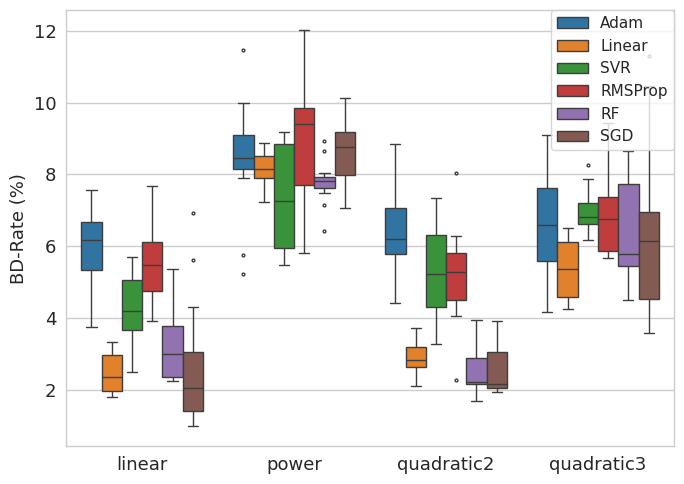

In [111]:
# 直观看一下区别: 总的来说 quadratic2 好像比较好
plt.figure(figsize=(7, 5))

# 1. 先画一下 BD-Rate
ax = sns.boxplot(data=avg_bdbr[avg_bdbr["bd_psnr"] < 0], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-Rate (%)")
ax.legend(handles, new_labels, borderaxespad=0., loc="upper right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDRate_PSNR.pdf", format="pdf")

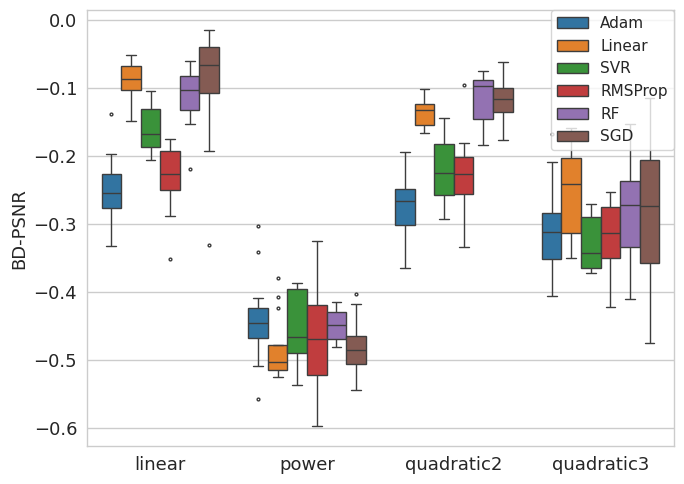

In [112]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)
plt.figure(figsize=(7, 5))

# 2. 再画一下 BD-PSNR
ax = sns.boxplot(data=avg_bdbr, x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-PSNR")
ax.legend(handles, new_labels, borderaxespad=0., loc="upper right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDBR_PSNR.pdf", format="pdf")

#### 2. Bitrate - ssim

In [43]:
import pandas as pd

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

pred_df = pd.read_csv(f"{table_dir}/predCurve/combined_preds.csv")
pred_df = pred_df.drop(columns=["p1", "p2", "p3", "pred_p1", "pred_p2", "pred_p3"])     # 不用看参数了

display(pred_df)
print(pred_df.columns.tolist())

,seqName,sceneId,regressor,input,preset,size,func,target,qp,pred_target,bitrate,log2bitrate,psnr,log2psnr,ssim,log2ssim,vmaf,log2vmaf,err
0,Lecture-42c3,0,Adam,(faster)x(360P),faster,1080P,linear,bitrate,22,675.249878,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,363.210522
1,Lecture-42c3,0,Adam,(medium)x(360P),faster,1080P,linear,bitrate,22,695.509933,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,342.950467
2,Lecture-42c3,0,Adam,(slower)x(360P),faster,1080P,linear,bitrate,22,1486.697418,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-448.237018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257789,Lecture-7e40,1,SGDRegressor,(faster)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.092571,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.104890
4257790,Lecture-7e40,1,SGDRegressor,(medium)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.029500,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.167961
4257791,Lecture-7e40,1,SGDRegressor,(slower)x(1080P),slower,720P,quadratic3,log2vmaf,52,5.804019,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.393442


['seqName', 'sceneId', 'regressor', 'input', 'preset', 'size', 'func', 'target', 'qp', 'pred_target', 'bitrate', 'log2bitrate', 'psnr', 'log2psnr', 'ssim', 'log2ssim', 'vmaf', 'log2vmaf', 'err']


#### 2.1 预测的是 log2ssim

In [44]:
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, verbose = args
    
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    ssim_df    = group[
        (group["target"] == "log2ssim") & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + ["log2ssim", "ssim"]].reset_index(drop=True)
    
    bitrate_df = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    ssim_df    = ssim_df.rename(columns={"pred_target": "pred_log2ssim"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(ssim_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    group_rd["pred_ssim"] = 2 ** group_rd["pred_log2ssim"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", "ssim"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", "pred_ssim"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    os.makedirs(f"{table_dir}/convex/RD-log2SSIM/{seqName}-scene{sceneId}", exist_ok=True)
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df.to_csv(f"{table_dir}/convex/RD-log2SSIM/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y="pred_ssim", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend(loc="lower right")
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    axes[0].set_ylabel("Predicted SSIM")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y="ssim", hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend(loc="lower right")
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel("Actual SSIM")
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    
    os.makedirs(f"{fig_dir}/convex/RD-log2SSIM/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/convex/RD-log2SSIM/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.png")
    plt.close()
    
    if verbose:
        display(group_rd)
        display(convex_df)
        plt.show()

In [45]:
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, verbose))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:07<00:00,  8.58it/s]


#### BD-BR (SSIM)

In [49]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/convex/RD-log2SSIM")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/convex/RD-log2SSIM/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/convex/RD-log2SSIM/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/convex/convex_log2ssim.csv", index=False)

100%|██████████| 831/831 [00:22<00:00, 36.14it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2ssim,log2ssim,ssim,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_ssim,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,52,-0.030759,-0.045960,0.968645,5.646284,5.779094,54.9137,50.084198,0.978905,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,52,-0.052013,-0.057960,0.960621,3.682048,4.471851,22.1902,12.835327,0.964590,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,52,-0.058208,-0.052381,0.964344,3.880789,4.886233,29.5735,14.731057,0.960456,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328424,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,37,-0.082121,-0.047537,0.967587,8.013295,8.224990,299.2050,258.370022,0.944668,actual
328425,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,42,-0.113923,-0.083558,0.943727,7.282748,7.441077,173.7750,155.713232,0.924072,actual
328426,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,47,-0.145724,-0.125267,0.916834,6.459726,6.840086,114.5700,88.017975,0.903926,actual


In [57]:
from metrics.bjontegaard import BD_PSNR
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_ssim = BD_PSNR(actual_convex_df["bitrate"].tolist(), actual_convex_df["ssim"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["ssim"].tolist(), piecewise=1)
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_ssim])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_ssim"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_ssim"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/convex/all_BDBR_log2SSIM.csv", index=False)

18162it [00:31, 570.83it/s]


,seqName,sceneId,regressor,func,input,preset,bd_ssim
0,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,-0.003701
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-0.008697
3,Lecture-42c3,0,Adam,linear,(faster)x(360P),faster,-0.002088
6,Lecture-42c3,0,Adam,linear,(faster)x(540P),faster,-0.007534
...,...,...,...,...,...,...,...
18158,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(540P),slower,-0.004165
18159,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),faster,-0.002408
18160,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-0.003272
18161,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-0.001505


,sceneId,bd_ssim
count,16147.000000,16147.000000
mean,3.510621,-0.003521
std,3.560322,0.002326
min,0.000000,-0.009148
25%,1.000000,-0.005146
50%,2.000000,-0.003384
75%,6.000000,-0.001524
max,11.000000,0.021645


In [58]:
# 看一下不同预测策略 (regressor, func, input) 的效果
grouped = all_bdbr.groupby(["regressor", "func", "input"], as_index=False)

rows = []
for (regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_ssim"].mean()])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_ssim"])
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/convex/avg_BDBR_log2SSIM.csv", index=False)

,regressor,func,input,bd_ssim
0,Adam,linear,(faster)x(1080P),-0.004122
1,Adam,linear,(faster)x(360P),-0.003492
2,Adam,linear,(faster)x(540P),-0.004122
3,Adam,linear,(faster)x(720P),-0.003892
...,...,...,...,...
284,SGDRegressor,quadratic3,(slower)x(1080P),-0.002790
285,SGDRegressor,quadratic3,(slower)x(360P),-0.002507
286,SGDRegressor,quadratic3,(slower)x(540P),-0.001727
287,SGDRegressor,quadratic3,(slower)x(720P),-0.002925


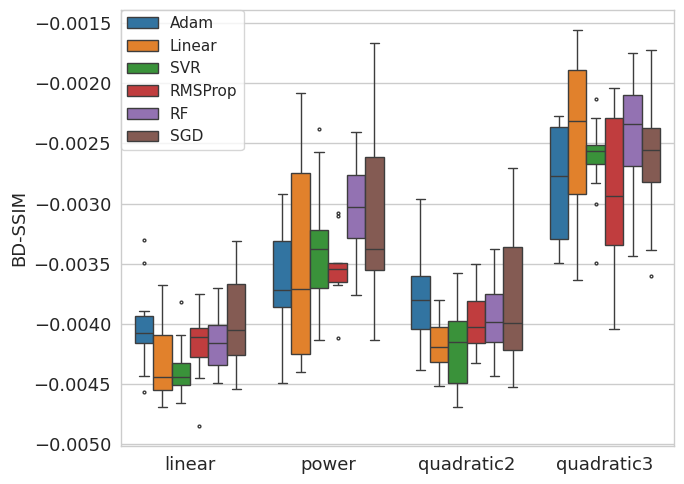

In [59]:
# 直观看一下区别: 总的来说 linear 好像比较好
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=avg_bdbr, x="func", y="bd_ssim", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-SSIM")
ax.legend(handles, new_labels, borderaxespad=0.)

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDBR_log2SSIM.pdf", format="pdf")

#### 2.2 预测的是 ssim

In [60]:
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, verbose = args
    
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    ssim_df    = group[
        (group["target"] == "ssim") & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + ["log2ssim", "ssim"]].reset_index(drop=True)
    
    bitrate_df = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    ssim_df    = ssim_df.rename(columns={"pred_target": "pred_ssim"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(ssim_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", "ssim"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", "pred_ssim"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    os.makedirs(f"{table_dir}/convex/RD-SSIM/{seqName}-scene{sceneId}", exist_ok=True)
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df.to_csv(f"{table_dir}/convex/RD-SSIM/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y="pred_ssim", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend(loc="lower right")
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    axes[0].set_ylabel("Predicted SSIM")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y="ssim", hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend(loc="lower right")
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel("Actual SSIM")
    
    plt.tight_layout()
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    os.makedirs(f"{fig_dir}/convex/RD-SSIM/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/convex/RD-SSIM/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.png")
    plt.close()
    
    if verbose:
        display(group_rd)
        display(convex_df)
        plt.show()

In [61]:
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for func in group["func"].unique():
        for regressor in group["regressor"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, verbose))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:05<00:00, 12.03it/s]


In [62]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/convex/RD-SSIM")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/convex/RD-SSIM/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/convex/RD-SSIM/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True)
display(convex_df)

convex_df.to_csv(f"{table_dir}/convex/convex_ssim.csv", index=False)

100%|██████████| 864/864 [00:16<00:00, 51.56it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_ssim,log2ssim,ssim,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,52,0.952353,-0.057960,0.960621,3.682048,4.471851,22.1902,12.835327,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,0.995322,-0.007097,0.995093,12.506482,12.602524,6219.2459,5818.701542,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,720P,22,0.995388,-0.009479,0.993451,11.518206,12.125150,4467.1839,2933.090905,pred
3,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,22,0.992722,-0.010033,0.993070,10.724766,11.567760,3035.5865,1692.295312,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328464,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,32,0.966512,-0.032810,0.977515,8.651368,8.770086,436.5750,402.088063,actual
328465,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,37,0.946134,-0.047537,0.967587,8.013295,8.224990,299.2050,258.370022,actual
328466,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,42,0.925756,-0.083558,0.943727,7.282748,7.441077,173.7750,155.713232,actual
328467,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,47,0.905378,-0.125267,0.916834,6.459726,6.840086,114.5700,88.017975,actual


#### BD-BR (SSIM) -> 比预测 log2ssim 的好一点

In [65]:
from metrics.bjontegaard import BD_PSNR

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])

rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)

    bd_ssim = BD_PSNR(actual_convex_df["bitrate"].tolist(), actual_convex_df["ssim"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["ssim"].tolist(), piecewise=0)
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_ssim])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_ssim"])
display(all_bdbr)

all_bdbr = rm_outliers(all_bdbr, cols=["bd_ssim"], threshold=0.75)
display(all_bdbr.describe())

all_bdbr.to_csv(f"{table_dir}/convex/all_BDBR_SSIM.csv", index=False)

19008it [00:25, 742.02it/s]


,seqName,sceneId,regressor,func,input,preset,bd_ssim
0,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,-0.006225
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-0.010999
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),slower,-0.007626
3,Lecture-42c3,0,Adam,linear,(faster)x(360P),faster,-0.007484
...,...,...,...,...,...,...,...
19004,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(540P),slower,-0.003458
19005,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),faster,-0.000219
19006,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,0.010672
19007,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-0.000928


,sceneId,bd_ssim
count,16595.000000,16595.000000
mean,3.565833,-0.002465
std,3.568429,0.058761
min,0.000000,-0.009415
25%,1.000000,-0.005016
50%,2.000000,-0.003184
75%,6.000000,-0.001280
max,11.000000,5.236810


In [66]:
# 看一下不同预测策略 (regressor, func, input) 的效果
grouped = all_bdbr.groupby(["regressor", "func", "input"], as_index=False)

rows = []
for (regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_ssim"].mean()])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_ssim"])
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/convex/avg_BDBR_SSIM.csv", index=False)

,regressor,func,input,bd_ssim
0,Adam,linear,(faster)x(1080P),-0.003413
1,Adam,linear,(faster)x(360P),-0.003714
2,Adam,linear,(faster)x(540P),-0.004008
3,Adam,linear,(faster)x(720P),-0.003752
...,...,...,...,...
284,SGDRegressor,quadratic3,(slower)x(1080P),-0.001790
285,SGDRegressor,quadratic3,(slower)x(360P),-0.002749
286,SGDRegressor,quadratic3,(slower)x(540P),0.001602
287,SGDRegressor,quadratic3,(slower)x(720P),-0.001435


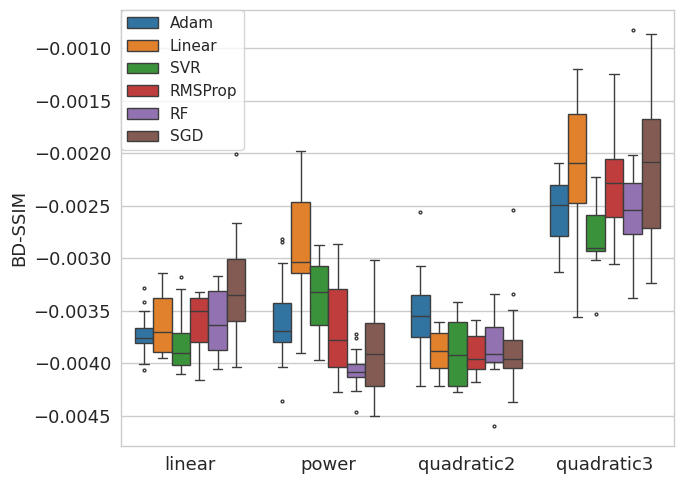

In [69]:
# 直观看一下区别: 总的来说 linear 好像比较好, 且好于预测 log2ssim
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=avg_bdbr[avg_bdbr["bd_ssim"] <= 0], x="func", y="bd_ssim", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-SSIM")
ax.legend(handles, new_labels, borderaxespad=0.)

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDBR_SSIM.pdf", format="pdf")

#### 3. Bitrate - VMAF

In [71]:
import pandas as pd
pd.set_option('display.max_rows', 6)

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

pred_df = pd.read_csv(f"{table_dir}/predCurve/combined_preds.csv")
pred_df = pred_df.drop(columns=["p1", "p2", "p3", "pred_p1", "pred_p2", "pred_p3"])     # 不用看参数了

display(pred_df)
print(pred_df.columns.tolist())

,seqName,sceneId,regressor,input,preset,size,func,target,qp,pred_target,bitrate,log2bitrate,psnr,log2psnr,ssim,log2ssim,vmaf,log2vmaf,err
0,Lecture-42c3,0,Adam,(faster)x(360P),faster,1080P,linear,bitrate,22,675.249878,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,363.210522
1,Lecture-42c3,0,Adam,(medium)x(360P),faster,1080P,linear,bitrate,22,695.509933,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,342.950467
2,Lecture-42c3,0,Adam,(slower)x(360P),faster,1080P,linear,bitrate,22,1486.697418,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-448.237018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257789,Lecture-7e40,1,SGDRegressor,(faster)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.092571,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.104890
4257790,Lecture-7e40,1,SGDRegressor,(medium)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.029500,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.167961
4257791,Lecture-7e40,1,SGDRegressor,(slower)x(1080P),slower,720P,quadratic3,log2vmaf,52,5.804019,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.393442


['seqName', 'sceneId', 'regressor', 'input', 'preset', 'size', 'func', 'target', 'qp', 'pred_target', 'bitrate', 'log2bitrate', 'psnr', 'log2psnr', 'ssim', 'log2ssim', 'vmaf', 'log2vmaf', 'err']


#### 3.1 预测的是 log2vmaf

In [72]:
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, verbose = args
    
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    vmaf_df    = group[
        (group["target"] == "log2vmaf") & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + ["log2vmaf", "vmaf"]].reset_index(drop=True)
    
    bitrate_df = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    vmaf_df    = vmaf_df.rename(columns={"pred_target": "pred_log2vmaf"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(vmaf_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    group_rd["pred_vmaf"] = 2 ** group_rd["pred_log2vmaf"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", "vmaf"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", "pred_vmaf"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    os.makedirs(f"{table_dir}/convex/RD-log2VMAF/{seqName}-scene{sceneId}", exist_ok=True)
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df.to_csv(f"{table_dir}/convex/RD-log2VMAF/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y="pred_vmaf", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend(loc="lower right")
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    axes[0].set_ylabel("Predicted VMAF")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y="vmaf", hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend(loc="lower right")
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel("Actual VMAF")
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    
    os.makedirs(f"{fig_dir}/convex/RD-log2VMAF/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/convex/RD-log2VMAF/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.png")
    plt.close()
    
    if verbose:
        display(group_rd)
        display(convex_df)
        plt.show()

In [73]:
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, verbose))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:05<00:00, 12.17it/s]


#### BD-BR (VMAF)

In [74]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/convex/RD-log2VMAF")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/convex/RD-log2VMAF/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/convex/RD-log2VMAF/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/convex/convex_log2vmaf.csv", index=False)

100%|██████████| 864/864 [00:18<00:00, 46.06it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2vmaf,log2vmaf,vmaf,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_vmaf,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,6.445319,6.609370,97.637913,12.506482,12.602524,6219.2459,5818.701542,87.143398,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,22,6.758271,6.608287,97.564672,10.724766,11.567760,3035.5865,1692.295312,108.253579,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,22,6.728930,6.599837,96.994878,9.470541,10.614585,1567.8646,709.442206,106.074223,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364133,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,47,5.943115,6.140042,70.523971,6.459726,6.840086,114.5700,88.017975,61.525607,actual
364134,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,52,5.762939,5.757876,54.111989,5.544230,6.072320,67.2900,46.663755,54.302215,actual
364135,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,540P,52,5.908293,5.662144,50.637851,6.341138,6.545196,93.3900,81.072328,60.058363,actual


In [75]:
from metrics.bjontegaard import BD_PSNR
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_vmaf = BD_PSNR(actual_convex_df["bitrate"].tolist(), actual_convex_df["vmaf"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=1)
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_vmaf"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_vmaf"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/convex/all_BDBR_log2VMAF.csv", index=False)

19008it [00:32, 576.19it/s]


,seqName,sceneId,regressor,func,input,preset,bd_vmaf
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-1.150353
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),slower,-4.879857
4,Lecture-42c3,0,Adam,linear,(faster)x(360P),medium,-2.259947
6,Lecture-42c3,0,Adam,linear,(faster)x(540P),faster,-4.288226
...,...,...,...,...,...,...,...
19004,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(540P),slower,-2.033389
19005,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),faster,-1.053324
19006,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-0.341147
19007,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-0.121263


,sceneId,bd_vmaf
count,16687.000000,16687.000000
mean,3.279020,-1.455362
std,3.490375,1.738404
min,0.000000,-5.760767
25%,1.000000,-2.518531
50%,2.000000,-1.277885
75%,6.000000,-0.251173
max,11.000000,4.634371


In [76]:
# 看一下不同预测策略 (regressor, func, input) 的效果
grouped = all_bdbr.groupby(["regressor", "func", "input"], as_index=False)

rows = []
for (regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_vmaf"].mean()])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_vmaf"])
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/convex/avg_BDBR_log2VMAF.csv", index=False)

,regressor,func,input,bd_vmaf
0,Adam,linear,(faster)x(1080P),-1.990111
1,Adam,linear,(faster)x(360P),-2.106997
2,Adam,linear,(faster)x(540P),-1.908865
3,Adam,linear,(faster)x(720P),-2.039799
...,...,...,...,...
284,SGDRegressor,quadratic3,(slower)x(1080P),-0.860796
285,SGDRegressor,quadratic3,(slower)x(360P),-1.008594
286,SGDRegressor,quadratic3,(slower)x(540P),-0.398246
287,SGDRegressor,quadratic3,(slower)x(720P),-0.860896


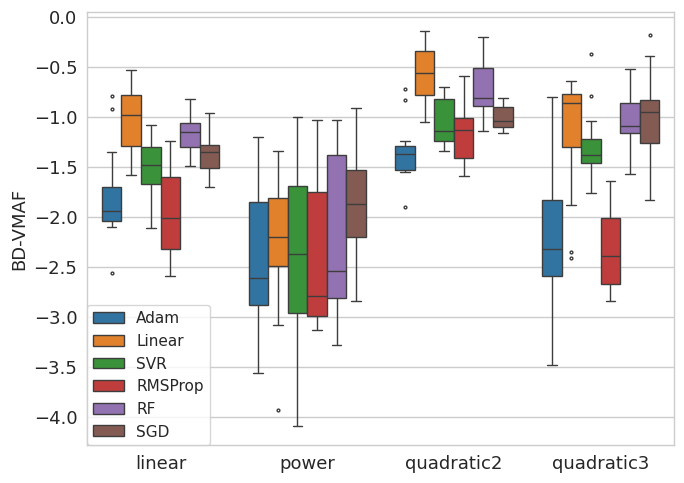

In [77]:
# 直观看一下区别: 总的来说 quadratic2 好像比较好
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=avg_bdbr, x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-VMAF")
ax.legend(handles, new_labels, borderaxespad=0.)

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDBR_log2VMAF.pdf", format="pdf")

#### 3.2 预测的是 vmaf

In [82]:
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, verbose = args
    
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    vmaf_df    = group[
        (group["target"] == "vmaf") & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + ["log2vmaf", "vmaf"]].reset_index(drop=True)
    
    bitrate_df = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    vmaf_df    = vmaf_df.rename(columns={"pred_target": "pred_vmaf"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(vmaf_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", "vmaf"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", "pred_vmaf"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    os.makedirs(f"{table_dir}/convex/RD-VMAF/{seqName}-scene{sceneId}", exist_ok=True)
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df.to_csv(f"{table_dir}/convex/RD-VMAF/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y="pred_vmaf", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend(loc="lower right")
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    axes[0].set_ylabel("Predicted VMAF")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y="vmaf", hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend(loc="lower right")
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel("Actual VMAF")
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    
    os.makedirs(f"{fig_dir}/convex/RD-VMAF/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/convex/RD-VMAF/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.png")
    plt.close()
    
    if verbose:
        display(group_rd)
        display(convex_df)
        plt.show()

In [83]:
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, verbose))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:07<00:00,  9.10it/s]


#### BD-BR (VMAF)

In [84]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/convex/RD-VMAF")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/convex/RD-VMAF/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/convex/RD-VMAF/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/convex/convex_vmaf.csv", index=False)

100%|██████████| 864/864 [00:21<00:00, 40.71it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_vmaf,log2vmaf,vmaf,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,720P,52,44.758430,6.166230,71.815851,4.420590,5.202332,36.8178,21.415596,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,56.061935,6.609370,97.637913,12.506482,12.602524,6219.2459,5818.701542,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,22,103.798292,6.599837,96.994878,9.470541,10.614585,1567.8646,709.442206,pred
3,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,27,98.138602,6.558610,94.262384,8.831721,8.990679,508.7028,455.630703,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370284,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,42,74.908373,6.328783,80.381002,7.282748,7.441077,173.7750,155.713232,actual
370285,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,47,67.268950,6.140042,70.523971,6.459726,6.840086,114.5700,88.017975,actual
370286,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,52,59.629528,5.757876,54.111989,5.544230,6.072320,67.2900,46.663755,actual
370287,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,540P,52,58.521230,5.662144,50.637851,6.341138,6.545196,93.3900,81.072328,actual


In [85]:
from metrics.bjontegaard import BD_PSNR
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_vmaf = BD_PSNR(actual_convex_df["bitrate"].tolist(), actual_convex_df["vmaf"].tolist(), pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=1)
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_vmaf"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_vmaf"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/convex/all_BDBR_VMAF.csv", index=False)

19008it [00:39, 476.54it/s]


,seqName,sceneId,regressor,func,input,preset,bd_vmaf
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-3.006639
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),slower,-2.239009
3,Lecture-42c3,0,Adam,linear,(faster)x(360P),faster,-2.957111
4,Lecture-42c3,0,Adam,linear,(faster)x(360P),medium,-4.455852
...,...,...,...,...,...,...,...
19004,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(540P),slower,-0.961160
19005,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),faster,-1.522276
19006,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-0.928898
19007,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-1.265462


,sceneId,bd_vmaf
count,16391.000000,16391.000000
mean,3.321030,-1.070355
std,3.495249,1.589324
min,0.000000,-5.154643
25%,1.000000,-2.025064
50%,2.000000,-0.837872
75%,6.000000,-0.000776
max,11.000000,3.340013


#### 预测 VMAF 性能似乎优于预测 log2VMAF

In [86]:
# 看一下不同预测策略 (regressor, func, input) 的效果
grouped = all_bdbr.groupby(["regressor", "func", "input"], as_index=False)

rows = []
for (regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_vmaf"].mean()])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_vmaf"])
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/convex/avg_BDBR_VMAF.csv", index=False)

,regressor,func,input,bd_vmaf
0,Adam,linear,(faster)x(1080P),-1.346904
1,Adam,linear,(faster)x(360P),-2.181995
2,Adam,linear,(faster)x(540P),-1.024749
3,Adam,linear,(faster)x(720P),-1.722436
...,...,...,...,...
284,SGDRegressor,quadratic3,(slower)x(1080P),-1.426503
285,SGDRegressor,quadratic3,(slower)x(360P),-0.169294
286,SGDRegressor,quadratic3,(slower)x(540P),-0.530190
287,SGDRegressor,quadratic3,(slower)x(720P),-0.947240


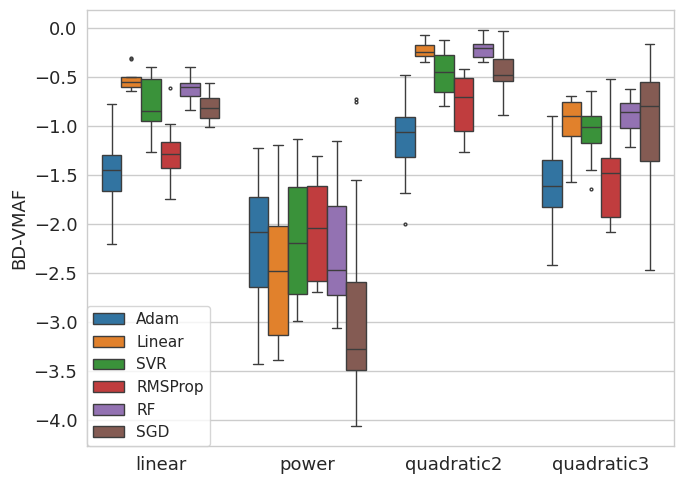

In [89]:
# 直观看一下区别: 总的来说 quadratic2 好像比较好
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=avg_bdbr[avg_bdbr["bd_vmaf"] < 0], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}
new_labels = [label_mapping[label] for label in labels]

ax.set_xlabel("")
ax.set_ylabel("BD-VMAF")
ax.legend(handles, new_labels, borderaxespad=0.)

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/convex/avg_BDBR_VMAF.pdf", format="pdf")